In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
from climatetranslation.unit.data import construct_regridders, reduce_height, get_dataset
xr.set_options(display_style="text")


In [2]:
reduce_dict = {0: ['pr'], 2: ['tas', 'tasmin', 'tasmax']}

In [3]:
ds_cam = get_dataset('/datadrive/cam5/nat_hist_zarr', level_vars=reduce_dict)
ds_had = get_dataset('/datadrive/hadgem3/nat_hist_zarr', level_vars=reduce_dict)

In [4]:
rg_cam, rg_had = construct_regridders(ds_cam, ds_had)

# attributes are stripped by regridding module. Save them
cam_attrs = {v:ds_cam[v].attrs for v in ds_cam.keys()}
had_attrs = {v:ds_cam[v].attrs for v in ds_cam.keys()}

# regridders allow lazy evaluation
ds_cam = ds_cam if rg_cam is None else rg_cam(ds_cam).astype(np.float32)
ds_had = ds_had if rg_had is None else rg_had(ds_had).astype(np.float32)

# reapply attributes
for v, attr in cam_attrs.items():
    ds_cam[v].attrs = attr
for v, attr in had_attrs.items():
    ds_had[v].attrs = attr

Create weight file: bilinear_324x432_192x288_peri.nc
Remove file bilinear_324x432_192x288_peri.nc
using dimensions ('lat', 'lon') from data variable pr as the horizontal dimensions for this dataset.


In [18]:
ds_a = ds_cam.isel(run=slice(0,2), time=slice(0, 1000), lon=slice(0,2), lat=slice(0,2)).compute()
ds_b = ds_had.isel(run=slice(0,2), time=slice(0, 1000), lon=slice(0,2), lat=slice(0,2)).compute()

In [6]:
from scipy.interpolate import interp1d


def translate_quantile_value_single_month(ds, quantile_values, value2quantile=True):

    def interpolate(x, xs, ys):
        if x > xs[-1]:
            return 1 if value2quantile else ys[-1]
        elif x < xs[0]:
            return 0 if value2quantile else ys[0]
        return interp1d(xs, ys, kind="linear")(x)
    
    return xr.merge([
        xr.apply_ufunc(
            interpolate,
            ds[k],
            quantile_values[k] if value2quantile else quantile_values.quantiles,
            quantile_values.quantiles if value2quantile else quantile_values[k],
            input_core_dims=[[], ['quantiles'], ['quantiles']],
            exclude_dims = {'quantiles',},
            vectorize=True
        ).rename(k) for k in ds.keys()
    ])



class CDF:
    def __init__(self, quantiles):
        self.quantiles = quantiles
        
    def fit(self, ds):
        self.quantile_values = ds.groupby('time.month').quantile(
            self.quantiles, dim=('time', 'run'), interpolation='linear'
        ).rename(name_dict={'quantile':'quantiles'})
        
    def plot(self, lat, lon, figsize=(6, 18)):
        kn = len(self.quantile_values.keys())
        plt.figure(figsize=figsize)
        for i, k in enumerate(self.quantile_values.keys()):
            plt.subplot(kn, 1, i+1)
            self.quantile_values[k].sel(lat=lat, lon=lon, method='nearest').plot.line(x='quantiles',  add_legend=i==0)
        plt.tight_layout()

    def transform(self, ds):
        results = []
        for month, group in ds.groupby('time.month'):
            results.append(
                translate_quantile_value_single_month(
                    group, 
                    self.quantile_values.sel(month=month),
                    value2quantile=True
                )
            )
        return xr.concat(results, dim='time').drop('month').sortby('time')
    
    def inverse_transform(self, ds):
        results = []
        for month, group in ds.groupby('time.month'):
            results.append(
                translate_quantile_value_single_month(
                    group, 
                    self.quantile_values.sel(month=month),
                    value2quantile=False
                )
            )
        return xr.concat(results, dim='time').drop('month').sortby('time')
    
    def save(self, filepath):
        self.quantile_values.to_netcdf(filepath)
        
    @classmethod
    def load(cls, filepath):
        if '*' in filepath:
            quantile_values = xr.open_mfdataset(filepath).load()
        else:
            quantile_values = xr.load_dataset(filepath)
        quantiles = quantile_values.quantiles.values
        cdf = CDF(quantiles)
        cdf.quantile_values = quantile_values
        return cdf
            
    
class QauntileMapping:
    def __init__(self, cdfa, cdfb):
        self.cdfa = cdfa
        self.cdfb = cdfb
        
    def transform_a2b(self, ds):
        return self.cdfb.inverse_transform(self.cdfa.transform(ds))
        
    def transform_b2a(self, ds):
        return self.cdfa.inverse_transform(self.cdfb.transform(ds))
        

In [495]:
eps=1e-3
N=10
quantiles = np.linspace(eps, 1-eps, N)
cdf_a = CDF(quantiles)

cdf_a.fit(ds_a)

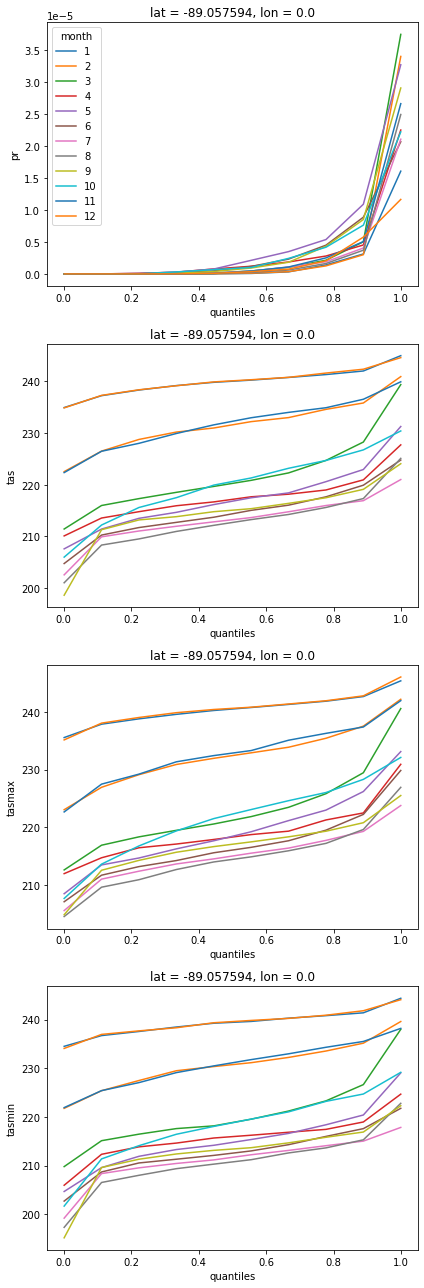

In [496]:
cdf_a.plot(0,0)

## Loop test

In [7]:
eps=1e-3
N=10
quantiles = np.linspace(eps, 1-eps, N)


for i in range(1,3):
    ds_a = ds_cam.isel(run=slice(0,2), time=slice(0, 1000), lon=slice(0,2*(i+1)), lat=slice(0,2)).compute()
    ds_b = ds_had.isel(run=slice(0,2), time=slice(0, 1000), lon=slice(0,2*(i+1)), lat=slice(0,2)).compute()

    cdf_a = CDF(quantiles)
    cdf_b = CDF(quantiles)
    
    cdf_a.fit(ds_a)
    cdf_b.fit(ds_b)
    
    cdf_a.save(f'/home/dfulu/model_outputs/quantile_mapping_models/cdf_cam_{i}.nc')
    cdf_b.save(f'/home/dfulu/model_outputs/quantile_mapping_models/cdf_had_{i}.nc')

## Translate after loading

In [16]:
cdf_a = CDF.load('/home/dfulu/model_outputs/quantile_mapping_models/cdf_cam_*.nc')
cdf_b = CDF.load('/home/dfulu/model_outputs/quantile_mapping_models/cdf_had_*.nc')

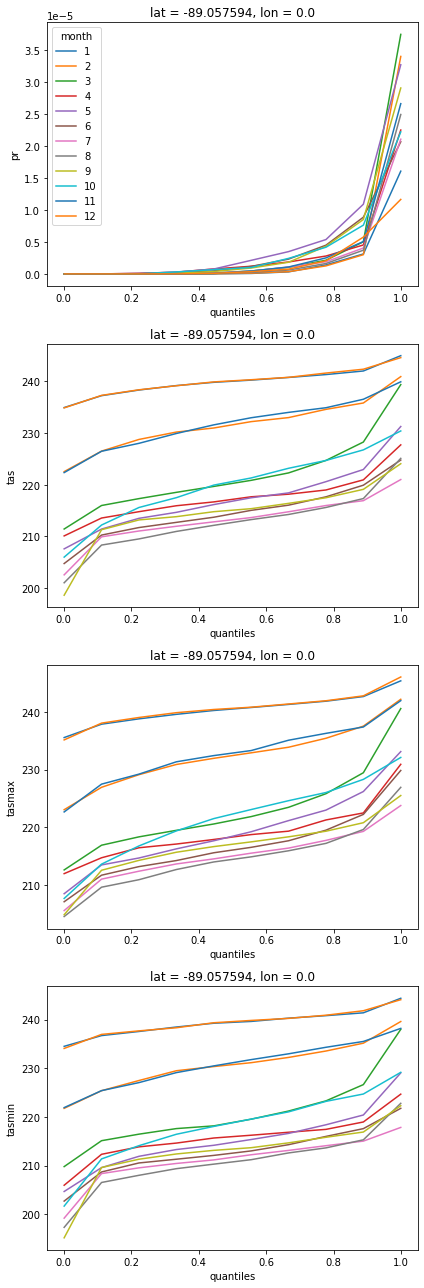

In [17]:
cdf_a.plot(0,0)

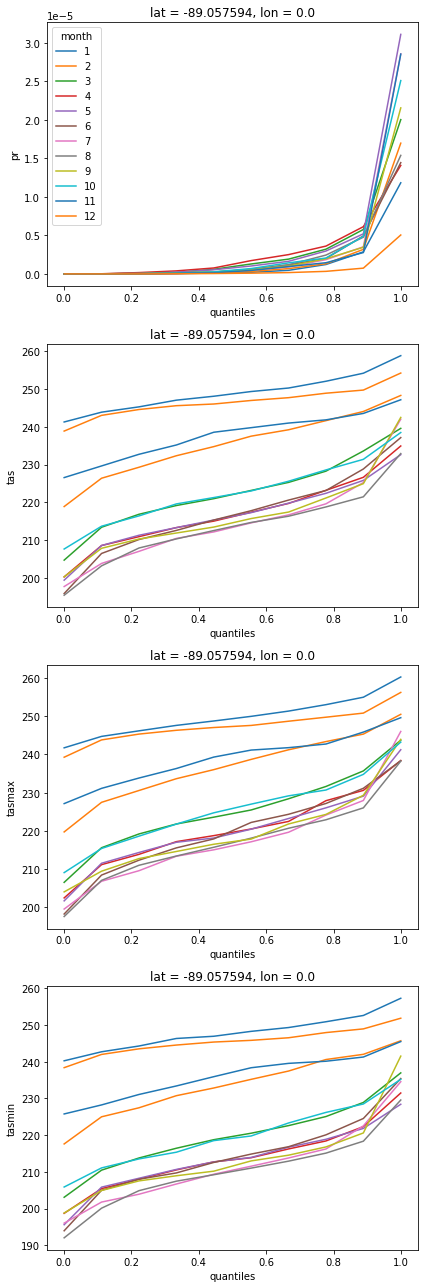

In [18]:
cdf_b.plot(0,0)

In [19]:
cdf_a.quantile_values

<xarray.Dataset>
Dimensions:    (lat: 2, lon: 6, month: 12, quantiles: 10)
Coordinates:
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * quantiles  (quantiles) float64 0.001 0.1119 0.2228 ... 0.7772 0.8881 0.999
  * lat        (lat) float32 -90.0 -89.057594
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 6.25
Data variables:
    pr         (month, quantiles, lat, lon) float64 0.0 0.0 ... 1.466e-05
    tas        (month, quantiles, lat, lon) float64 235.5 236.1 ... 245.1 245.1
    tasmax     (month, quantiles, lat, lon) float64 236.0 236.6 ... 246.7 246.8
    tasmin     (month, quantiles, lat, lon) float64 235.2 235.7 ... 244.2 244.1

In [20]:
cdf_a.quantile_values - cdf_b.quantile_values

<xarray.Dataset>
Dimensions:    (lat: 2, lon: 6, month: 12, quantiles: 10)
Coordinates:
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * quantiles  (quantiles) float64 0.001 0.1119 0.2228 ... 0.7772 0.8881 0.999
  * lat        (lat) float32 -90.0 -89.057594
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 6.25
Data variables:
    pr         (month, quantiles, lat, lon) float64 0.0 0.0 ... 9.878e-06
    tas        (month, quantiles, lat, lon) float64 -5.873 -5.285 ... -9.261
    tasmax     (month, quantiles, lat, lon) float64 -6.197 -5.568 ... -9.608
    tasmin     (month, quantiles, lat, lon) float64 -5.498 -4.979 ... -7.682

In [21]:
((cdf_a.quantile_values - cdf_b.quantile_values)==0).mean()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    pr       float64 0.0375
    tas      float64 0.0
    tasmax   float64 0.0
    tasmin   float64 0.0

In [22]:
qm = QauntileMapping(cdf_a, cdf_b)

In [23]:
ds_a = ds_cam.isel(run=slice(0,2), time=slice(0, 1000), lon=slice(0,6), lat=slice(0,2))
ds_b = ds_had.isel(run=slice(0,2), time=slice(0, 1000), lon=slice(0,6), lat=slice(0,2))

In [25]:


output_zarr = "/datadrive/cam5/nat_hist_to_hadgem3_qm-v1_zarr_test"
x2x = 'a2b'
n_times = 50

mode = 'w-'
append_dim = None

ds = ds_a if x2x=='a2b' else ds_b
N_times = len(ds.time)

import progressbar

with progressbar.ProgressBar(max_value=N_times) as bar:
        
        for i in range(0, N_times, n_times):
            
            # transform through network 
            ds_mapped = qm.transform_a2b(ds.isel(time=slice(i, min(i+n_times, N_times))).compute())
            
            # fix chunking
            ds_mapped = ds_mapped.chunk(dict(run=1, time=1, lat=-1, lon=-1))
            
            # append to zarr
            ds_mapped.to_zarr(
                output_zarr, 
                mode=mode, 
                append_dim=append_dim,
                consolidated=True
            )
            
            # update progress bar and change modes so dat can be appended
            bar.update(i)
            mode, append_dim='a', 'time'
            
        bar.update(N_times)

100% (1000 of 1000) |####################| Elapsed Time: 0:00:28 Time:  0:00:28


In [26]:
ds_load = xr.open_zarr(output_zarr, consolidated=True)

In [27]:
ds_load

<xarray.Dataset>
Dimensions:  (lat: 2, lon: 6, run: 2, time: 1000)
Coordinates:
  * lat      (lat) float32 -90.0 -89.057594
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 6.25
  * run      (run) int64 1 2
  * time     (time) object 1959-01-01 12:00:00 ... 1961-09-27 12:00:00
Data variables:
    pr       (run, time, lat, lon) float64 dask.array<chunksize=(1, 1, 2, 6), meta=np.ndarray>
    tas      (run, time, lat, lon) float64 dask.array<chunksize=(1, 1, 2, 6), meta=np.ndarray>
    tasmax   (run, time, lat, lon) float64 dask.array<chunksize=(1, 1, 2, 6), meta=np.ndarray>
    tasmin   (run, time, lat, lon) float64 dask.array<chunksize=(1, 1, 2, 6), meta=np.ndarray>

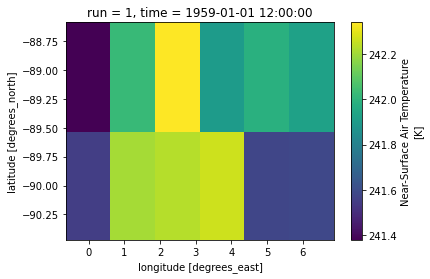

In [28]:
ds_a.tas.isel(time=0, run=0).plot()

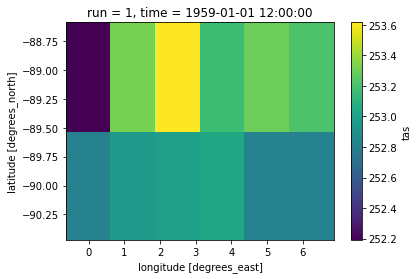

In [29]:
ds_load.tas.isel(time=0, run=0).plot()

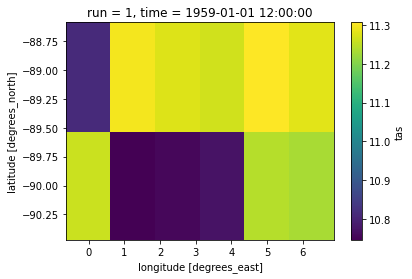

In [30]:
(ds_load.tas.isel(time=0, run=0) - ds_a.tas.isel(time=0, run=0)).plot()

In [34]:
np.linspace(0, 1034, 10).astype(int)

array([   0,  114,  229,  344,  459,  574,  689,  804,  919, 1034])